Importing necessary packages

In [2]:
# Install OpenSlide and set the path to the installed directory below
OPENSLIDE_PATH = r'C:\\NovinoAI\\openslide-bin-4.0.0.2-windows-x64\\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [3]:
from openslide import OpenSlide
from typing import List, Dict, Tuple
import random
import numpy as np
import pandas as pd
import skimage.io
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import tqdm
import cv2
import glob
from tqdm.notebook import tqdm
from multiprocessing import Pool
from visual_helpers import plot_img_mask_details, create_image_from_tiles, create_tiles, create_tiles_object_from_images


Input Data Source

In [4]:
DATASET_FOLDER_PATH: str = os.path.join(os.path.abspath('..'), 'dataset')
PANDA_DATASET_NAME: str = 'prostate-cancer-grade-assessment'
PANDA_DATASET_FOLDER_PATH: str = os.path.join(DATASET_FOLDER_PATH, PANDA_DATASET_NAME)
PANDA_IMAGE_FOLDER_PATH: str = os.path.join(PANDA_DATASET_FOLDER_PATH, 'train_images')
PANDA_MASKS_FOLDER_PATH: str = os.path.join(PANDA_DATASET_FOLDER_PATH, 'train_label_masks')
TRAIN_DATA_CSV_PATH: str = os.path.join(PANDA_DATASET_FOLDER_PATH, 'train.csv')
TEST_DATA_CSV_PATH: str = os.path.join(PANDA_DATASET_FOLDER_PATH, 'test.csv')

In [5]:
df_train_data: pd.DataFrame = pd.read_csv(TRAIN_DATA_CSV_PATH)
df_train_data.head()

,image_id,data_provider,isup_grade,gleason_score,is_present
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,1
2,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
3,002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0,1
4,003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3,1


In [6]:
# Creating list of image/mask pairs in the Dataset
def check_image_pairs_exist(image_id):
    img_file_path: str = f'{PANDA_IMAGE_FOLDER_PATH}/{image_id}.tiff'
    mask_file_path: str = f'{PANDA_MASKS_FOLDER_PATH}/{image_id}_mask.tiff'

    score = 0
    if os.path.exists(img_file_path):
        score += 1
    if os.path.exists(mask_file_path):
        score += 1
    
    if score == 2:
        # Both image and mask for this 'image_id' exist
        return 1
    else:
        # Either image or mask for this 'image_id' is missing
        return 0

df_train_data['is_present'] = df_train_data.apply(lambda x: check_image_pairs_exist(x['image_id']), axis=1)
df_train_data.to_csv(TRAIN_DATA_CSV_PATH, index=False)

<Axes: >

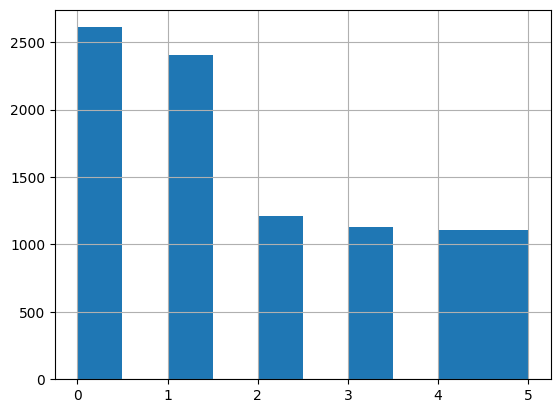

In [7]:
list_image_ids: List[str] = list(df_train_data[df_train_data.is_present == 1].image_id.values)
df_train_data.isup_grade.hist()

Visualizing a sample slide image

6edc4da86334190089f6a093bf258ab6
(4608, 11776)
((4608, 11776), (1152, 2944), (288, 736))
(4608, 11776)
((4608, 11776), (1152, 2944), (288, 736))


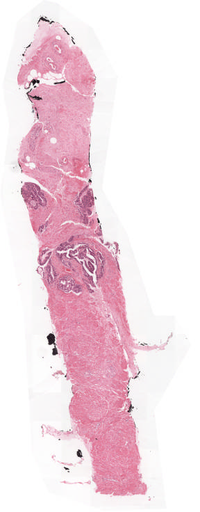

In [8]:
# Choosing a random slide image for viewing
num_total_images: int = len(df_train_data)
image_idx: int = random.randint(0, num_total_images)
# image_idx = 157
print(df_train_data.loc[image_idx].image_id)

# Loading the slide image using OpenSlide
slide_mask: OpenSlide = openslide.OpenSlide(f'{PANDA_IMAGE_FOLDER_PATH}/{df_train_data.loc[image_idx].image_id}.tiff')
slide_dims: Tuple[int, int] = slide_mask.dimensions
slide_level_dims: Tuple[Tuple[int, int]] = slide_mask.level_dimensions

slide_mask1: OpenSlide = openslide.OpenSlide(f'{PANDA_MASKS_FOLDER_PATH}/{df_train_data.loc[image_idx].image_id}_mask.tiff')
slide_dims1: Tuple[int, int] = slide_mask1.dimensions
slide_level_dims1: Tuple[Tuple[int, int]] = slide_mask1.level_dimensions

print(slide_dims)
print(slide_level_dims)

print(slide_dims1)
print(slide_level_dims1)

# Displaying the image as a 512x512 RGB image
display(slide_mask.get_thumbnail(size=(512, 512)))

In [9]:
# Loading the slide image using OpenSlide
def plot_something(selected_idx):
    selected_image_id: str = df_train_data.loc[selected_idx].image_id
    selected_data_provider: str = df_train_data.loc[selected_idx].data_provider

    selected_slide_img: OpenSlide = openslide.OpenSlide(f'{PANDA_IMAGE_FOLDER_PATH}/{selected_image_id}.tiff')
    selected_slide_mask: OpenSlide = openslide.OpenSlide(f'{PANDA_MASKS_FOLDER_PATH}/{selected_image_id}_mask.tiff')

    plot_img_mask_details(selected_slide_img, selected_slide_mask, center=selected_data_provider)

selected_idx = widgets.Dropdown(
    options=list(map(tuple, df_train_data[['image_id']].reset_index()[['image_id', 'index']].values)),
    description='Input TIFF File:',
)

interact(plot_something, selected_idx=selected_idx)

interactive(children=(Dropdown(description='Input TIFF File:', options=(('0005f7aaab2800f6170c399693a96917', 0…

<function __main__.plot_something(selected_idx)>

In [10]:
def plot_something_2(selected_idx, level_dim, num_tiles, tile_size):
    selected_image_id: str = df_train_data.loc[selected_idx].image_id

    img: np.ndarray = skimage.io.ImageCollection(os.path.join(PANDA_IMAGE_FOLDER_PATH, f'{selected_image_id}.tiff'))[level_dim]
    mask: np.ndarray = skimage.io.ImageCollection(os.path.join(PANDA_MASKS_FOLDER_PATH, f'{selected_image_id}_mask.tiff'))[level_dim]
    tiles: List[Dict[any]] = create_tiles(img, mask, num_tiles, tile_size)
    big_img: np.ndarray = create_image_from_tiles(tiles, num_tiles, tile_size).astype(np.uint8)
    display(Image.fromarray(big_img))
    

dd_selected_idx_2 = widgets.Dropdown(
    options=list(map(tuple, df_train_data[['image_id']].reset_index()[['image_id', 'index']].values)),
    description='Input TIFF File:',
)

dd_level_dims= widgets.Dropdown(options=[('', 2)], value=2, description='Level Dimensions:')
dd_num_tiles= widgets.Dropdown(options=[('16', 16), ('25', 25), ('36', 36)], value=16, description='Number of Tiles:')
dd_tile_sizes = widgets.Dropdown(options=[('128 x 128', 128), ('256 x 256', 256)], value=128, description='Tile Sizes:')

# Define a function that updates the content of y based on what we select for x
def update(*args):
    selected_image_id: str = df_train_data.loc[dd_selected_idx_2.value].image_id
    selected_slide_img: OpenSlide = openslide.OpenSlide(f'{PANDA_IMAGE_FOLDER_PATH}/{selected_image_id}.tiff')
    slide_level_dims: Tuple[Tuple[int, int]] = selected_slide_img.level_dimensions
    dd_level_dims.options = [(str(slide_level_dims[2]), 2), (str(slide_level_dims[1]), 1), (str(slide_level_dims[0]), 0)]
    dd_level_dims.value = 2
dd_selected_idx_2.observe(update)

interact(plot_something_2, selected_idx=dd_selected_idx_2, level_dim=dd_level_dims, num_tiles=dd_num_tiles, tile_size=dd_tile_sizes)

interactive(children=(Dropdown(description='Input TIFF File:', options=(('0005f7aaab2800f6170c399693a96917', 0…

<function __main__.plot_something_2(selected_idx, level_dim, num_tiles, tile_size)>

## Creating Tiled Dataset from the Original PANDA dataset

In [11]:
list_image_ids = list(df_train_data.image_id.values)

NUM_TILES: int = 36
TILE_SIZE: int = 256

TILED_DATASET_NAME: str = f'tiled-prostate-{NUM_TILES}x{TILE_SIZE}x{TILE_SIZE}'
TILED_DATASET_FOLDER_PATH: str = os.path.join(DATASET_FOLDER_PATH, TILED_DATASET_NAME)
TILED_IMAGE_FOLDER_PATH: str = os.path.join(TILED_DATASET_FOLDER_PATH, 'images')
TILED_MASKS_FOLDER_PATH: str = os.path.join(TILED_DATASET_FOLDER_PATH, 'masks')

# Creating the output folder(s) for the new tiles dataset
os.makedirs(TILED_DATASET_FOLDER_PATH, exist_ok=True)
os.makedirs(TILED_IMAGE_FOLDER_PATH, exist_ok=True)
os.makedirs(TILED_MASKS_FOLDER_PATH, exist_ok=True)

def create_tiled_dataset(image_id, num_tiles, tile_size, level_dim=1):
    og_img: np.ndarray = skimage.io.ImageCollection(os.path.join(PANDA_IMAGE_FOLDER_PATH, f'{image_id}.tiff'),
                                                    conserve_memory=True)[level_dim]
    og_mask: np.ndarray = skimage.io.ImageCollection(os.path.join(PANDA_MASKS_FOLDER_PATH, f'{image_id}_mask.tiff'),
                                                        conserve_memory=True)[level_dim]
    list_tiles: List[Dict[any]] = create_tiles(og_img, og_mask, num_tiles, tile_size)
    for t in list_tiles:
        img_tile, mask_tile, idx = t['img'], t['mask'], t['idx']

        # #if read with PIL RGB turns into BGR
        # img_tile = cv2.imencode('.png', cv2.cvtColor(img_tile, cv2.COLOR_RGB2BGR))[1]
        # # img_out.writestr(f'{image_id}_{idx}.png', img_tile)
        # mask_tile = cv2.imencode('.png',mask_tile[:,:,0])[1]
        # # mask_out.writestr(f'{image_id}_{idx}.png', mask_tile)
        
        img_tile = cv2.cvtColor(img_tile, cv2.COLOR_RGB2BGR)
        mask_tile = mask_tile[:,:,0]

        tile_file_name: str = f'{image_id}_{idx}.png'
        cv2.imwrite(os.path.join(TILED_IMAGE_FOLDER_PATH, tile_file_name), img_tile)
        cv2.imwrite(os.path.join(TILED_MASKS_FOLDER_PATH, tile_file_name), mask_tile)
    return image_id

Visualize the new tiled Dataset

In [12]:
def plot_something_3(selected_idx):
    # print(selected_idx)
    selected_image_id: str = df_train_data.loc[selected_idx].image_id
    selected_data_provider: str = df_train_data.loc[selected_idx].data_provider
    
    list_tile_img_files: List[str] = glob.glob(os.path.join(TILED_IMAGE_FOLDER_PATH, f'{selected_image_id}_*'))
    list_tile_mask_files: List[str] = glob.glob(os.path.join(TILED_MASKS_FOLDER_PATH, f'{selected_image_id}_*'))
    num_total_tiles: int = len(list_tile_img_files)
    # print(num_total_tiles)
    
    list_tiles = create_tiles_object_from_images(list_tile_img_files, list_tile_mask_files)
    big_img: np.ndarray = create_image_from_tiles(list_tiles, num_total_tiles, list_tiles[0]['img'].shape[0]).astype(np.uint8)
    big_mask: np.ndarray = create_image_from_tiles(list_tiles, num_total_tiles, list_tiles[0]['img'].shape[0], 'mask').astype(np.uint8)
    display(Image.fromarray(big_img))
    
    big_mask = Image.fromarray(big_mask)
    preview_palette = np.zeros(shape=768, dtype=int)
    if selected_data_provider == 'radboud':
        # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
        preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
    elif selected_data_provider == 'karolinska':
        # Mapping: {0: background, 1: benign, 2: cancer}
        preview_palette[0:9] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 1, 0, 0]) * 255).astype(int)
    big_mask.putpalette(data=preview_palette.tolist())
    big_mask = big_mask.convert(mode='RGB')
    display(big_mask)

dd_selected_idx_3 = widgets.Dropdown(
    options=list(map(tuple, df_train_data[['image_id']].reset_index()[['image_id', 'index']].values)),
    description='Input TIFF File:',
)

interact(plot_something_3, selected_idx=dd_selected_idx_3)

interactive(children=(Dropdown(description='Input TIFF File:', options=(('0005f7aaab2800f6170c399693a96917', 0…

<function __main__.plot_something_3(selected_idx)>